# How does transfer learning impact neural networks?

**Authors**:
- Adam Klekowski
- Paweł Kruczkiewicz
- Piotr Makarewicz

*(opis problemu)*

## Preparation
### Importing libraries

In [1]:
import os
import time

import numpy as np
import tensorflow as tf
from tensorflow import keras


import matplotlib.pyplot as plt


2023-06-10 18:23:12.514969: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-10 18:23:12.635567: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-10 18:23:12.635584: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-06-10 18:23:12.653188: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-10 18:23:13.093632: W tensorflow/stream_executor/platform/de

In [2]:

gpus = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))
if len(gpus) > 0:
    tf.config.experimental.set_memory_growth(gpus[0], True)


Num GPUs Available:  0


2023-06-10 18:23:13.816683: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-06-10 18:23:13.816702: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-06-10 18:23:13.816720: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ASUS-Zenbook-14): /proc/driver/nvidia/version does not exist


### Utility functions

In [3]:
## consts
DATA_FOLDER="data-trimmed"

INPUT_SHAPE = (256, 256, 3)
BATCH_SIZE = 32

In [4]:
# Class and function for showing the chart of validation accuracy and loss

class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

def plot_train_results(history, times, title):
    h = history.history
    loss, acc, val_loss, val_acc = h["loss"], h["categorical_accuracy"], h["val_loss"], h["val_categorical_accuracy"]
    avg_epoch_time = np.round(np.mean(times), 1)
    x = np.arange(len(loss)) + 1

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(f"{title} [Avg epoch time: {avg_epoch_time} s]")
    
    ax1.set_title("accuracy")
    ax1.plot(x, acc, label="Test")
    ax1.plot(x, val_acc, label="Validation")
    ax1.set_ylim([0, 1])
    ax1.legend()
    
    ax2.set_title("loss")
    ax2.plot(x, loss, label="Test")
    ax2.plot(x, val_loss, label="Validation")
    ax2.set_ylim([0, 5])
    ax2.legend()  
    
    
# training the model and plotting training results
def train_and_check_model(model, model_name, t_ds, v_ds, epochs=150, lr_scale=1):
    time_history = TimeHistory()

    model.compile(optimizer=keras.optimizers.Nadam(learning_rate=0.001*lr_scale),
                  loss="categorical_crossentropy", metrics=[keras.metrics.CategoricalAccuracy()])
    history = model.fit(t_ds,
                    validation_data=v_ds,
                    batch_size=BATCH_SIZE,
                    epochs=epochs,
                    callbacks=[time_history])

    model.save(f"./models/{model_name}")
    
    plot_train_results(history, time_history.times, model_name)

### Downloading and preparing data

In [5]:
# ! wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
# ! tar xzvf food-101.tar.gz
# ! mv food-101 data
# ! rm food-101.tar.gz

In [6]:
import os
import random
import shutil

SAMPLES_PER_CLASS = 256
OLD_FOLDER = "data/images"
NEW_FOLDER = "data-trimmed"
CHOSEN_CLASSES = {'apple_pie', 'pizza', 'hamburger', 'spaghetti_bolognese', 'chocolate_cake', 'hot_dog', 'ice_cream',
                  'carrot_cake', 'chicken_curry', 'churros', 'falafel', 'fish_and_chips', 'french_fries', 'hummus',
                  'greek_salad', 'panna_cotta', 'nachos', 'lasagna', 'tacos', 'risotto'}
NUM_CLASSES = len(CHOSEN_CLASSES)

print(f'There are {NUM_CLASSES} chosen classes: {CHOSEN_CLASSES}')

if not os.path.exists(NEW_FOLDER):
    os.mkdir(NEW_FOLDER)

for class_label in CHOSEN_CLASSES:
    old_class_dir = f"{OLD_FOLDER}/{class_label}"
    new_class_dir = f"{NEW_FOLDER}/{class_label}"

    if not os.path.exists(new_class_dir):
        os.mkdir(new_class_dir)
        print(f"Creating {new_class_dir}")

    list_of_samples = os.listdir(old_class_dir)
    trimmed_samples = random.sample(list_of_samples, SAMPLES_PER_CLASS)
    print(f"Number of samples: {len(trimmed_samples)}")

    for sample_name in trimmed_samples:
        shutil.copyfile(f"{old_class_dir}/{sample_name}", f"{new_class_dir}/{sample_name}")
        print(f"Copying {sample_name} to {new_class_dir}")

There are 20 chosen classes: {'ice_cream', 'panna_cotta', 'hamburger', 'apple_pie', 'carrot_cake', 'hot_dog', 'risotto', 'spaghetti_bolognese', 'lasagna', 'falafel', 'chicken_curry', 'fish_and_chips', 'nachos', 'greek_salad', 'pizza', 'hummus', 'chocolate_cake', 'churros', 'french_fries', 'tacos'}
Creating data-trimmed/ice_cream
Number of samples: 256
Copying 2157238.jpg to data-trimmed/ice_cream
Copying 347478.jpg to data-trimmed/ice_cream
Copying 1314535.jpg to data-trimmed/ice_cream
Copying 1777856.jpg to data-trimmed/ice_cream
Copying 423168.jpg to data-trimmed/ice_cream
Copying 2693460.jpg to data-trimmed/ice_cream
Copying 383969.jpg to data-trimmed/ice_cream
Copying 575058.jpg to data-trimmed/ice_cream
Copying 2940666.jpg to data-trimmed/ice_cream
Copying 2319680.jpg to data-trimmed/ice_cream
Copying 2000307.jpg to data-trimmed/ice_cream
Copying 3920024.jpg to data-trimmed/ice_cream
Copying 1371104.jpg to data-trimmed/ice_cream
Copying 2278442.jpg to data-trimmed/ice_cream
Copyin

### Importing data

In [7]:
train_ds, validation_ds = keras.utils.image_dataset_from_directory(
    directory=DATA_FOLDER,
    label_mode='categorical',
    image_size=(256, 256),
    validation_split=0.2,
    subset="both",
    seed=21)

Found 5120 files belonging to 20 classes.
Using 4096 files for training.
Using 1024 files for validation.


2023-06-10 18:23:14.889588: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


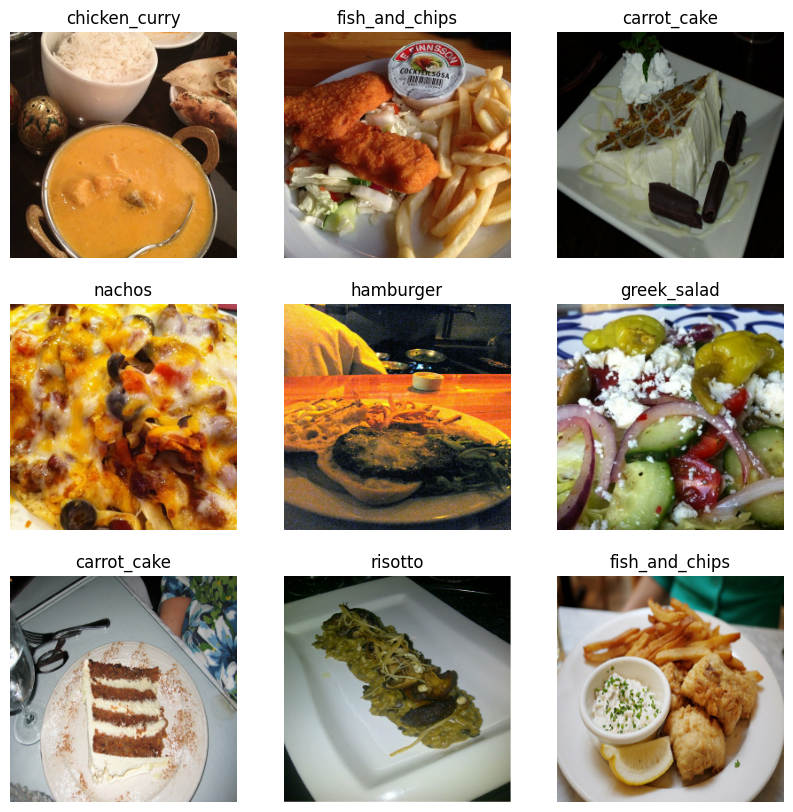

In [8]:
labels = sorted(os.listdir(DATA_FOLDER))

plt.figure(figsize=(10,10))

for (batch_of_images, batch_of_labels) in train_ds.take(1):
    batch_of_images = batch_of_images[:9]
    batch_of_labels = batch_of_labels[:9]
    for i, (image, inferred_label) in enumerate(zip(batch_of_images, batch_of_labels)):
        image = image / 255
        label = labels[np.nonzero(np.array(inferred_label))[0][0]]
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image)
        plt.title(label)
        plt.axis("off")

## EfficientNetV2B0

### Using EfficientNetV2B0 "as is"

In [9]:
efficient_net = keras.applications.EfficientNetV2B0(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(256, 256, 3),
    include_top=False,
    include_preprocessing=False)  # Do not include the ImageNet classifier at the top.

efficient_net.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 128, 128, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn (BatchNormalization)   (None, 128, 128, 32  128         ['stem_conv[0][0]']              
                                )                                                 

In [10]:
DROPOUT_RATE = 0.6
L1_PENALTY = 1e-5
L2_PENALTY = 1e-5

def create_transferred_model(base_model):
    base_model.trainable = False   # 🔫👮‍♂️ Freezing the base model
    
    inputs = keras.Input(shape=(256, 256, 3),
                         batch_size=BATCH_SIZE)
    scaled = keras.layers.Rescaling(scale=1./255.)(inputs) 
    
    x_base = base_model(scaled, training=False)
    gap_layer = keras.layers.GlobalAveragePooling2D()(x_base)

    dropout_layer = keras.layers.Dropout(DROPOUT_RATE)(gap_layer)
    
    outputs = keras.layers.Dense(NUM_CLASSES,
                                 activation="softmax",
                                 kernel_regularizer=keras.regularizers.L1L2(l1=L1_PENALTY, l2=L2_PENALTY),
                                 )(dropout_layer)
    return keras.models.Model(inputs, outputs)


In [11]:
transferred_model = create_transferred_model(efficient_net)
transferred_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(32, 256, 256, 3)]       0         
                                                                 
 rescaling (Rescaling)       (32, 256, 256, 3)         0         
                                                                 
 efficientnetv2-b0 (Function  (None, 8, 8, 1280)       5919312   
 al)                                                             
                                                                 
 global_average_pooling2d (G  (32, 1280)               0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (32, 1280)                0         
                                                                 
 dense (Dense)               (32, 20)                  25620 

Trying it without training

In [12]:
without_training = transferred_model
without_training.compile(optimizer="adam", loss="categorical_crossentropy", metrics=[keras.metrics.CategoricalAccuracy()])
without_training.evaluate(validation_ds)

32/32 [==============================] - 17s 500ms/step - loss: 3.0971 - categorical_accuracy: 0.0576


[3.0970988273620605, 0.0576171875]

128/128 [==============================] - 74s 579ms/step - loss: 1.6439 - categorical_accuracy: 0.5476 - val_loss: 1.5374 - val_categorical_accuracy: 0.6240
Epoch 7/100
128/128 [==============================] - 75s 586ms/step - loss: 1.5576 - categorical_accuracy: 0.5781 - val_loss: 1.4634 - val_categorical_accuracy: 0.6328
Epoch 8/100
128/128 [==============================] - 73s 569ms/step - loss: 1.4644 - categorical_accuracy: 0.5947 - val_loss: 1.4030 - val_categorical_accuracy: 0.6426
Epoch 9/100
128/128 [==============================] - 74s 580ms/step - loss: 1.4215 - categorical_accuracy: 0.6086 - val_loss: 1.3553 - val_categorical_accuracy: 0.6533
Epoch 10/100
128/128 [==============================] - 72s 562ms/step - loss: 1.3664 - categorical_accuracy: 0.6184 - val_loss: 1.3153 - val_categorical_accuracy: 0.6562
Epoch 11/100
128/128 [==============================] - 77s 605ms/step - loss: 1.3198 - categorical_accuracy: 0.6401 - val_loss: 1.2820 - val_categorical_accurac

INFO:tensorflow:Assets written to: ./models/Transfer learning model/assets


INFO:tensorflow:Assets written to: ./models/Transfer learning model/assets


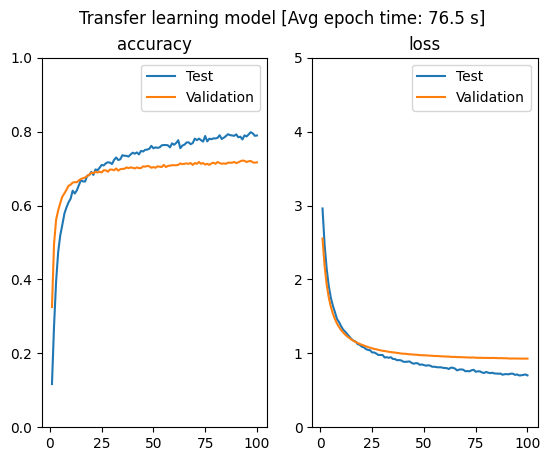

In [13]:
train_and_check_model(transferred_model, "Transfer learning model", t_ds=train_ds, v_ds=validation_ds, epochs=100, lr_scale=0.2)

In [ ]:
def fine_tune(model_after_transfer_learning):
    base_model_idx = 2
    base_model = model_after_transfer_learning.get_layer(index=base_model_idx)
    base_model.trainable = True

    train_and_check_model(model_after_transfer_learning, 
                          "Fine tuned ConvNeXt", 
                          t_ds=train_ds, 
                          v_ds=validation_ds, 
                          epochs=5, lr_scale=0.01)


fine_tune(transferred_model)

## Szybkie notki - do wywalenia w wersji finalnej (od Pawła)

  1. Tensorflow wymaga sporo czasu na zasetapowanie, warto założyć, że spokojnie zajmie to jakieś 2 h dla sprzętu bez zainstalowanych sterowników
  2. Wybrany dataset jest całkiem fajny jeżeli chodzi o transfer learning i fine_tuning, bo ma okropnie brzydkie zdjęcia, często poodwracane i źle skadrowane. Jedyny minus, to że jest ich dużo - napisałem skrypt `trim_dataset.py`, który przekopiowuje z folderu głównego zdjęcia na mniejszy dataset z ustaloną liczbą zdjęć per klasa (ja testowałem początkowo na 50, później zwiększyłem do 100).
  3. Zgodnie z przewidywaniami - zbiór danch nie pokrywa się pod względem klas z imagenetem. Dowód: estymacja nieuczonego modelu na zbiorze walidacyjnym dla food_101 wynosi mniej więcej 1/liczba klas.
  4. Kolejne ułatwienie - można nieco zmniejszyć liczbę klas o połowę albo 3/4. Dzięki temu dużo łatwiej jest trenować sieć przy transfer learningu. Jedyne, o co można się martwić, to że wyniki dla niektórych modeli będą zbyt dobre.
  5. Testowane przeze mnie sieci to **`convNext Tiny`** (który nie jest tak *tiny* jak się wydaje) i **`eficientNetV2B0`**. 
     - Convnext` miał słabe wyniki (max 20% poprawności przy raptem 20 klasach) z szbyką, niemal natychmiastową stagnacją, a do tego uczył się bardzo długo. Przy fine-tuningu rzucił OOM i nawet przy batchu 1 nie dało rady tego poprawić. Wyrzuciłem póki co jego dane z uczenia się ze względu na rzeczony OOM, jednak zapewne jest to do odpalenia na lepszej maszynce bądź przy odmrożeniu kilku warstw.
     - `EfficientNet` uczy się szybko, szybko też się przeucza. Przy fine-tuningu po 5 epokach osiągnął 100% accuracy. Przy transferlearningu też jakieś 25 epok wystarcza, by zobaczyć regres na zbiorze walidacyjnym. **Być może dropout przed warstwą gęstą byłby dobrym rozwiązaniem**

  6. Jakieś inne architektury sieci dostępne w kerasie są wymienione [tutaj](https://keras.io/api/applications/). Z mniejszych niż efficientNet zostały już chyba tylko mobilne. Może te też warto sprawdzić?
  7. Można transfer learning i fine-tuning sprawdzić jeszcze pod kątem:
    -  różnych danych (różna liczba klas oraz klas per funkcja)
    -  zastosowania dropoutu
    - różnych architektur

  8. Możliwe ulepszenia:
     - pokazać, dla jakich zdjęć sieć się myli, a dla jakich nie
     - zrobić własne zdjęcie i sprawdzić, czy dany model ogarnie :3
     - narysować ładniejsze wykresy
  9. Jak się zrobi folder o nazwie `model`, to ten notebook zapisze wytrenowany model. To bardzo dobry checkpoint.